In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import os
import sys


""" Workaround for notebooks to import packages from the parent folder """
# Get the project root directory by navigating up from the current directory
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Project root:", project_root)

from tools.data_loader import DataLoader
from tools.utils import get_column_list_from_json
from tools import config


# Debugging variables
showplots = True

# Used to load our datasets and compare them easily
data_loader = DataLoader()

# Null percentages

### Plotting the percentages of null variables for each unique variable we matched from companyfacts.

Loading dataset: column_statistics.csv


C:\Users\Angelo\AppData\Local\Temp\ipykernel_22248\3947024918.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=columns_to_plot_df, x='percentage_nulls', y='column', palette='viridis')


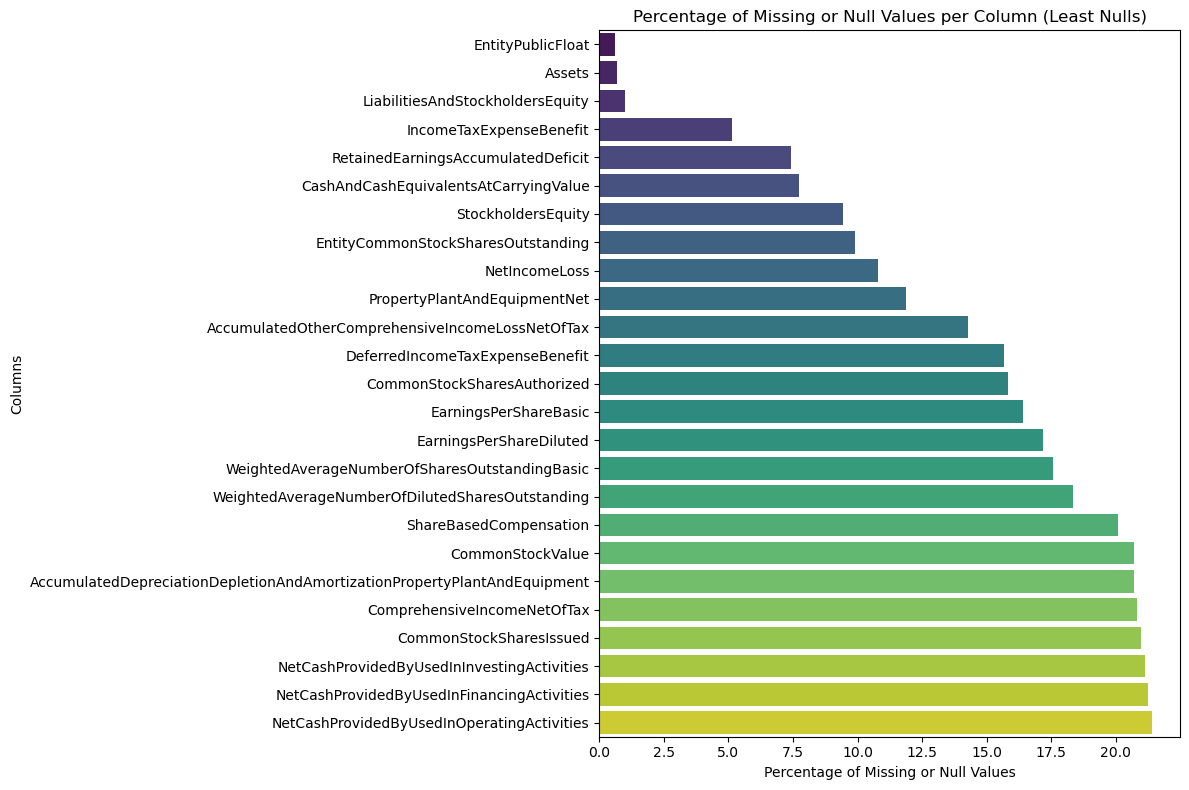

In [5]:

if showplots:
    # Read column statistics we generated earlier
    file_path = config.COLUMN_STATS_FILEPATH
    data_loader.load_dataset(file_path, alias="column_stats")
    columns_stats_df = data_loader.get_dataset("column_stats")

    # Sort by percentage_nulls in ascending order (least nulls first)
    columns_stats_df = columns_stats_df.sort_values(by='percentage_nulls')


    # Plotting the distribution of null percentages for columns with the least nulls
    max_columns_to_plot = 25
    columns_to_plot_df = columns_stats_df.head(max_columns_to_plot)

    plt.figure(figsize=(12, 8))
    sns.barplot(data=columns_to_plot_df, x='percentage_nulls', y='column', palette='viridis')
    plt.title('Percentage of Missing or Null Values per Column (Least Nulls)')
    plt.xlabel('Percentage of Missing or Null Values')
    plt.ylabel('Columns')
    plt.tight_layout()
    plt.show()

# Boxplots for the variables with the least amounts of null values

Loading dataset: ecl_companyfacts.json

Dense submatrix shape: (9249, 20)


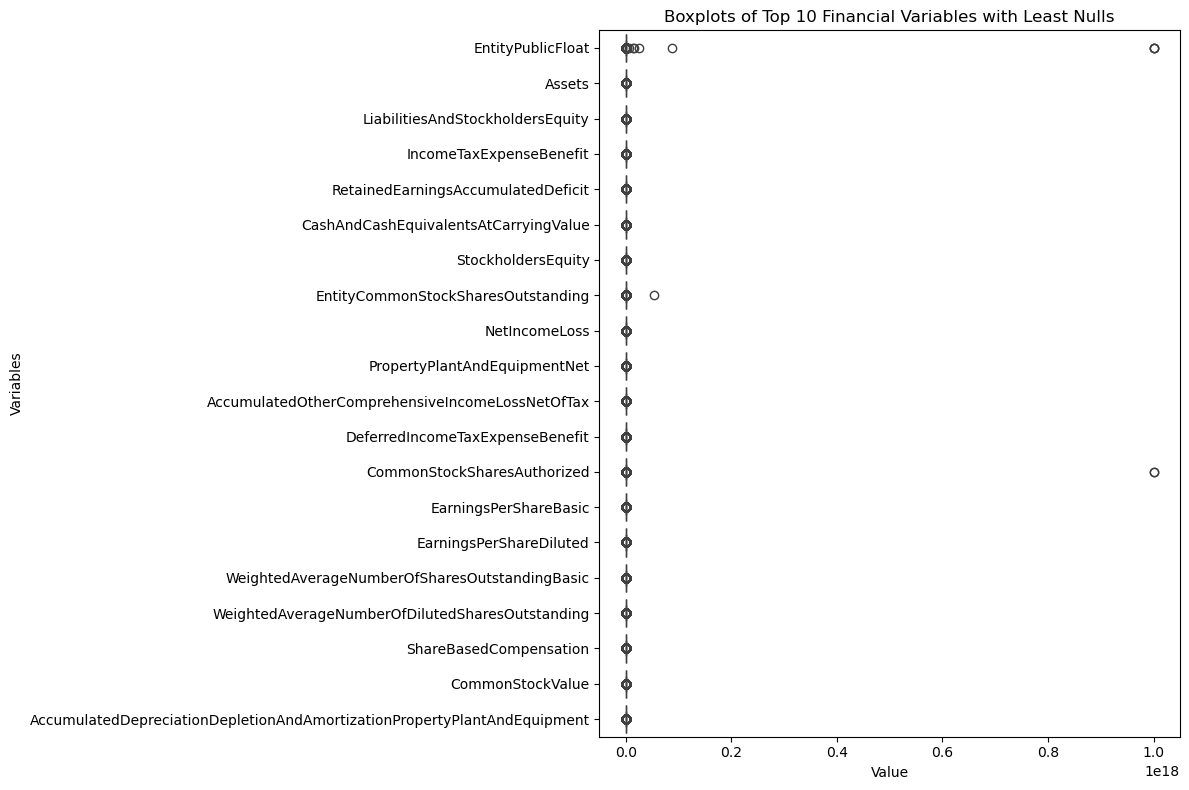

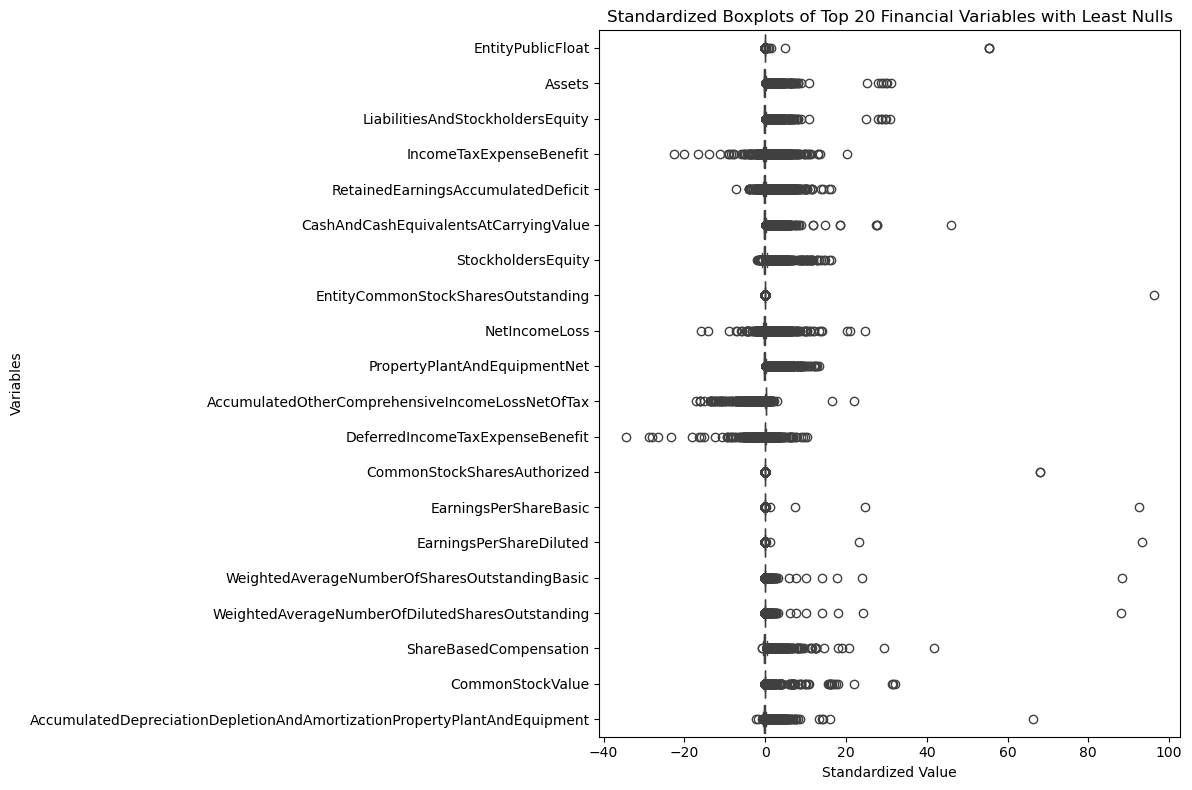

In [3]:
if showplots:    
    # Retrieve the column names of the variables with the least amount of nulls
    top_cols_threshold = 20
    top_columns = columns_stats_df.head(top_cols_threshold)['column'].tolist()

    # Read the combined ecl dataset generated earlier
    data_loader.load_dataset(config.ALL_VARS_DATASET_FILEPATH, alias="ecl_companyfacts", lines=True)
    ecl_companyfacts = data_loader.get_dataset("ecl_companyfacts")

    data_to_plot = ecl_companyfacts[top_columns]

    # Drop rows with nulls in these columns
    data_to_plot = data_to_plot.dropna(subset=top_columns)

    # Ensure all columns are numeric
    numeric_columns = data_to_plot.select_dtypes(include=[np.number]).columns.tolist()

    data_to_plot = data_to_plot[numeric_columns]

    # Check if we have at least one numeric column
    if not numeric_columns:
        print("No numeric columns found among the top 10 columns.")
    else:
        print(f"\nDense submatrix shape: {data_to_plot.shape}")
        # Boxplots without standardization
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=data_to_plot, orient='h')
        plt.title('Boxplots of Top 10 Financial Variables with Least Nulls')
        plt.xlabel('Value')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.show()

        # Standardize the data for better comparison
        scaler = StandardScaler()
        data_scaled = pd.DataFrame(scaler.fit_transform(data_to_plot), columns=numeric_columns)

        # Boxplots w standardization
        plt.figure(figsize=(12, 8))
        sns.boxplot(data=data_scaled, orient='h')
        plt.title(f'Standardized Boxplots of Top {top_cols_threshold} Financial Variables with Least Nulls')
        plt.xlabel('Standardized Value')
        plt.ylabel('Variables')
        plt.tight_layout()
        plt.show()


# Correlation Matrix

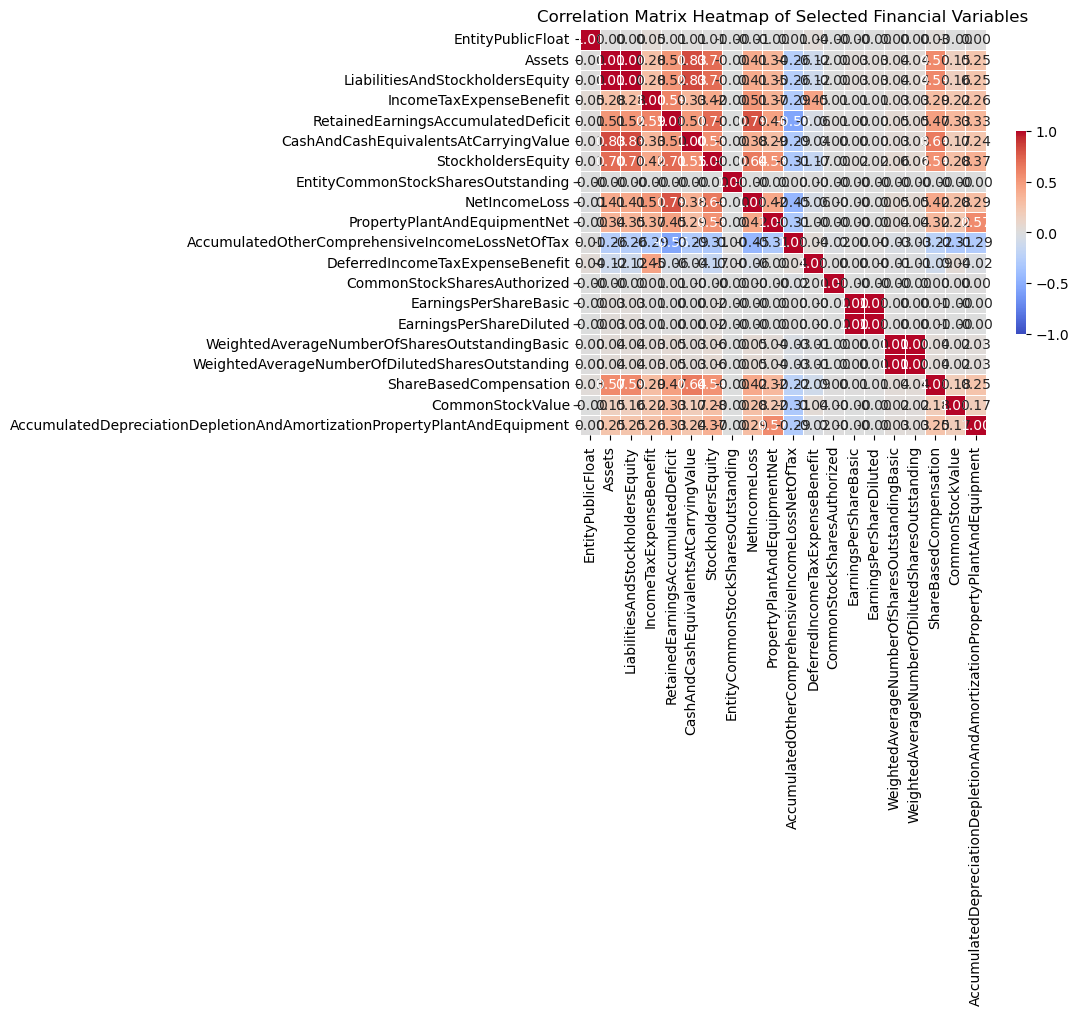

In [4]:
data_for_correlation = ecl_companyfacts[numeric_columns].dropna()

# Check if there are enough variables to compute correlations
if len(numeric_columns) < 2:
    print("Not enough numeric columns with the specified null percentage threshold to compute correlations.")
else:
    # Compute the correlation matrix
    corr_matrix = data_for_correlation.corr('pearson')
    
    plt.figure(figsize=(12, 10))

    # Generate a mask for the upper triangle (optional)
    # mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # add below with mask = mask

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr_matrix, cmap='coolwarm', vmax=1.0, vmin=-1.0, center=0,
                square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .5})

    plt.title('Correlation Matrix Heatmap of Selected Financial Variables')
    plt.tight_layout()
    plt.show()